# Phase Curves

From the previous two tutorials you should understand how: 

1. How to convert your GCM input to `PICASO`'s required `xarray`
2. How to post-process output to append to your GCM output

Here you will learn: 

1. How to compute a phase curve
2. How to analyze the resulting output

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
os.environ['PYSYN_CDBS']="/Users/nbatalh1/Documents/data/grp/hst/cdbs"
from picaso import justdoit as jdi
from picaso import justplotit as jpi
jpi.output_notebook()

Loading BokehJS ...

## Run Thermal Phase Curve w/ 3D Input

Computing a phase curve is identical to computing 3D spectra. The only difference is that you will need to **rotate the GCM longitude grid such that the visible portion of the planet changes as the phase changes.** 

We can experiment with doing this with our original xarray input:

In [2]:
opacity = jdi.opannection(wave_range=[1,1.7])

In [3]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True)

### Add Chemistry (randomized for purposes of the example)

Add chemistry, if not already included in your GCM output. Here, we are using the user-defined input. 

In [4]:
# create coords
lon = gcm_out.coords.get('lon').values
lat = gcm_out.coords.get('lat').values
pres = gcm_out.coords.get('pressure').values

fake_chem_H2O = np.random.rand(len(lon), len(lat),len(pres))*0.1+0.1 # create fake data
fake_chem_H2 = 1-fake_chem_H2O # create data

# put data into a dataset
ds_chem = jdi.xr.Dataset(
    data_vars=dict(
        H2O=(["x", "y","z"], fake_chem_H2O,{'units': 'v/v'}),
        H2=(["x", "y","z"], fake_chem_H2,{'units': 'v/v'}),
    ),
    coords=dict(
        lon=(["x"], lon,{'units': 'degrees'}), #required
        lat=(["y"], lat,{'units': 'degrees'}), #required
        pressure=(["z"], pres,{'units': 'bar'})#required*
    ),
    attrs=dict(description="coords with vectors"),
)
all_gcm = gcm_out.update(ds_chem)

Setup phase curve grid by defining the type of phase curve (thermal or reflected) as well as the phase angle grid. 

If you have not gone through the previous tutorials on xarray, post processing input, and computing 3D spectra, we highly recommend you look at that documentation. 

In [5]:
case_3d = jdi.inputs()
n_phases = 4
min_phase = 0 
max_phase = 2*np.pi
phase_grid = np.linspace(min_phase,max_phase,n_phases)#between 0 - 2pi
#send params to phase angle routine
case_3d.phase_angle(phase_grid=phase_grid, 
                    num_gangle=6, num_tangle=6,calculation='thermal')

### Use `shift` parameter to determine rotation of planet 

For each orbital `phase`, `picaso` will rotate the longitude grid `phase_i`+`shift_i`. For example, for tidally locked planets, `shift`=0 at all phase angles since the sub-solar point never changes. 

Therefore, `shift` must be input as an array of length `n_phase`. In this example, we will only explore tidally locked planets and will input a zero array. Use `plot=True` below to get a better idea of how your GCM grid is being shifted. 

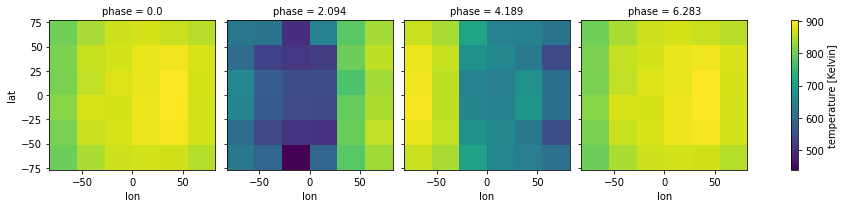

In [6]:
case_3d.atmosphere_phase(all_gcm,
                                    shift = np.zeros(n_phases), 
                                     plot=True,verbose=False)

Easy plotting different phases with `xarray` functionality (remember our H2O selection was random, so the plot will not be to enlightening) 

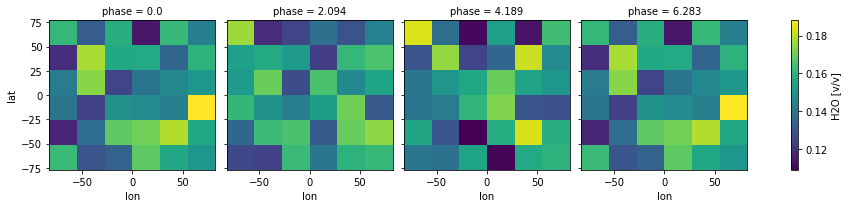

In [7]:
case_3d.inputs['atmosphere']['profile']['H2O'].isel(z=52).plot(
                                              x='lon', y ='lat',
                                              col='phase',col_wrap=4)

Set gravity and stellar parameters as usual

In [8]:
case_3d.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'), 
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun')) 

All is setup. Proceed with phase curve calculation.

In [9]:
allout = case_3d.phase_curve(opacity, n_cpu = 3,#jdi.cpu_count(),
                             full_output=True)

## Analyze Phase Curves

All original plotting tools still work by selecting an individual phase

In [17]:
#same old same old
wno =[];fpfs=[];legend=[]
for iphase in allout.keys():
    w,f = jdi.mean_regrid(allout[iphase]['wavenumber'],
                               allout[iphase]['fpfs_thermal'],R=100)
    wno+=[w]
    fpfs+=[f*1e6]
    legend +=[str(int(iphase*180/np.pi))]
jpi.show(jpi.spectrum(wno, fpfs, plot_width=500,legend=legend,
                     palette=jpi.viridis(n_phases)))

### Phase Curve Plotting Tools: Phase Snaps

Phase snaps allows you to show snapshots of what is happening at each phase that was computed. x,y,z axes can be swapped out for flexibility. 

- Allowable x: `'longitude', 'latitude', 'pressure'`
- Allowable y: `'longitude', 'latitude', 'pressure'` 
- Allowable z: `'temperature','taugas','taucld','tauray','w0','g0','opd'` (*the latter three are cloud properties*)
- Allowable collapse: 
    Collapse tells picaso what to do with the extra axes. For instance, taugas is an array that is `[npressure,nwavelength,nlongitude,nlatitude]`. If we want `pressure x latitude` we have to collapse wavelength and the longitude axis. To do so we could either supply an integer value to select a single dimension. Or we could supply one of the following as `str` input: [np.mean, np.median, np.min, np.max]. If there are multiple axes you want to collapse, supply an ordered list. 

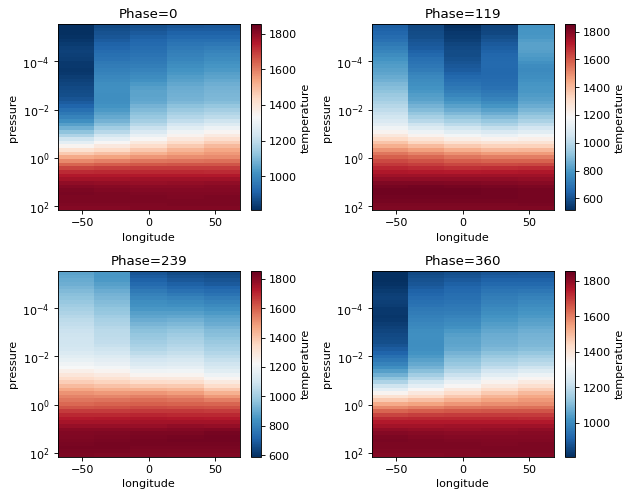

In [11]:
fig=jpi.phase_snaps(allout, x='longitude', y='pressure',z='temperature', 
                y_log=True, z_log=False, collapse='np.mean')#this will collapse the latitude axis by taking a mean

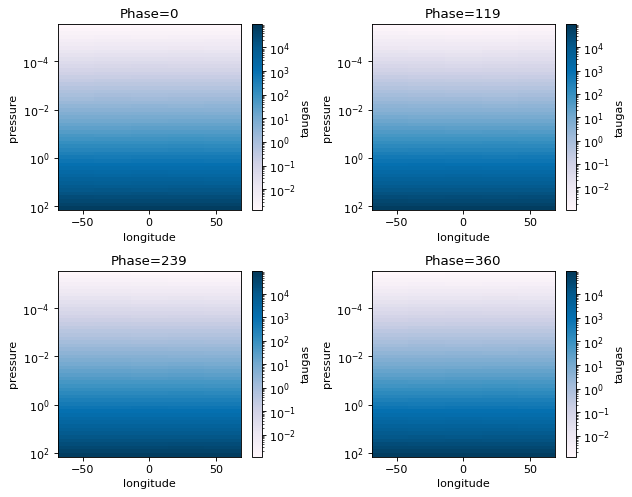

In [12]:
fig=jpi.phase_snaps(allout, x='longitude', y='pressure',z='taugas', palette='PuBu',
                y_log=True, z_log=True, collapse=['np.mean','np.mean'])
#this will collapse the latitude axis by taking a mean, and the wavelength axis also by taking the mean

Pressure at 0.0030016929695969906


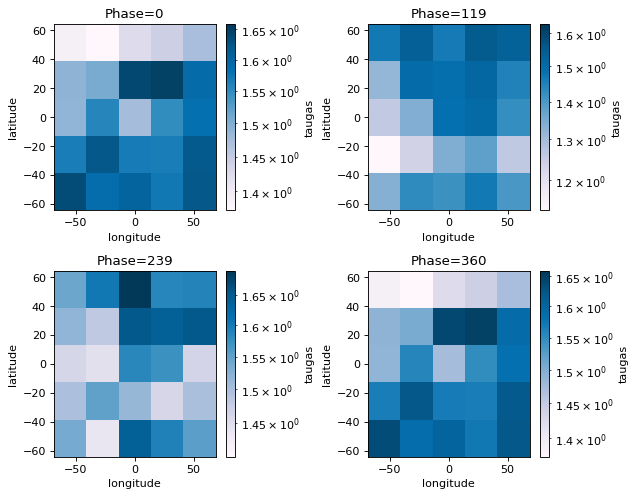

In [13]:
fig=jpi.phase_snaps(allout, x='longitude', y='latitude',z='taugas', palette='PuBu',
                y_log=False, z_log=True, collapse=[20,'np.mean'])
#this will collapse the pressure axis by taking the 10th pressure grid point 
#and the wavelength axis by taking the mean
print('Pressure at', allout[iphase]['full_output']['layer']['pressure'][20,0,0])

### Phase Curve Plotting Tools: Phase Curves

We can use the same `collapse` feature as in the `phase_snaps` tool to collapse the wavelength axis, when plotting phase curves. For example, we can select a single wavelength point at a given resolution, or we can average over all wavelengths. 

Allowable collapse: 
- `'np.mean'` or `np.sum`
- float or list of float: wavelength in microns (will find the nearest value to this wavelength). Must be in wavenumber range. 

For `float` option, user must specify resolution. 

In [19]:
to_plot = 'fpfs_thermal'#or thermal 
collapse = [1.1,1.4,1.6]#micron
R=100
phases, all_curves, all_ws, fig=jpi.phase_curve(allout, to_plot, collapse=collapse, R=100)
jpi.show(fig)

/Users/nbatalh1/.conda/envs/xesmf_env/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/nbatalh1/Documents/data/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/nbatalh1/.conda/envs/xesmf_env/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/nbatalh1/Documents/data/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/nbatalh1/.conda/envs/xesmf_env/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/nbatalh1/Documents/data/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
/Users/nbatalh1/Documents/codes/PICASO/picaso/picaso/atmsetup.py:130: UserWarning: Ignoring phase in input file, not a recog